In [1]:
import os
import sys
sys.path.append(os.path.expandvars("$HOME/NEXT/NEXT100-0nubb-analysis"))
import glob
import numpy  as np
import pandas as pd
import zfit

from invisible_cities.evm.mixer import get_file_number
from invisible_cities.io.dst_io import load_dst, load_dsts
from invisible_cities.core.system_of_units import keV, MeV

from fitting_tools.pdf_manager import pdf

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/util/execution.py:74: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
def load_dsts_with_info(inpath, isotope, g4volume, group, table, nfiles=100):
    
    filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume=g4volume))
                      , key = get_file_number)
    
    dst = pd.DataFrame()
    for filename in filenames[:nfiles]:
        dst_ = load_dst(filename, group, table)
        dst_.loc[:, "file"] = get_file_number(filename)
        dst = pd.concat([dst, dst_])
    return dst

In [3]:
inpath = os.path.expandvars("$HOME/NEXT/DATA/backgrounds/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

isotope  = "208Tl"
g4volume = "ICS"

filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume=g4volume))
                  , key = get_file_number)

#dsts   = load_dsts_with_info(inpath, isotope, g4volume,      "DST", "Events", nfiles=1000)
tracks = load_dsts_with_info(inpath, isotope, g4volume, "Tracking", "Tracks", nfiles=1000)

In [4]:
def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

In [5]:
# cuts

# 1S1-1S2
# included

# spurious tracks
tracks = remove_spurious_tracks(tracks.set_index(["event", "file"]), 0.01)

# 1-track
tracks = tracks[tracks.numb_of_tracks == 1]

# fiducial R<470
tracks = tracks[tracks.r_max<470]

# E > 2 MeV
tracks = tracks[tracks.energy>2]

KeyError: "None of ['event', 'file'] are in the columns"

In [ ]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

bins = np.arange(2, 2.7, 0.003)

ax.hist(tracks.energy, bins=bins, histtype="step", label="Track")
ax.set_xlabel("Energy (MeV)")
fig.tight_layout();

In [29]:
bins = np.arange(2, 2.7, 0.008)

#photopeak
emin, emax = 2.59, 2.65
de_compt = 0.01
de_phot  = 0.003

bins_compt = np.arange(   2, emin, de_compt)
bins_phot  = np.arange(emin, emax, de_phot)
bins = np.append(bins_compt, bins_phot)

binc = (bins[:-1] + bins[1:])/2.
h, _ = np.histogram(tracks.energy, bins=bins)

a_pdf = pdf(numpdf=(bins, h))

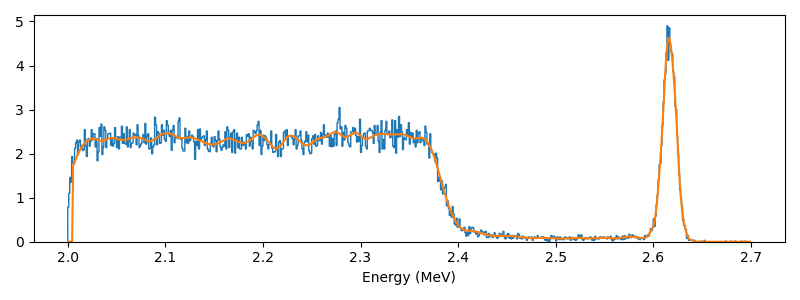

In [30]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

bins = np.arange(2, 2.7, 0.001)
binc = (bins[1:] + bins[:-1])/2.

ax.hist(tracks.energy, bins=bins, histtype="step", label="Track", density=True)
ax.plot(binc, a_pdf.pdf(binc))

ax.set_xlabel("Energy (MeV)")
fig.tight_layout();

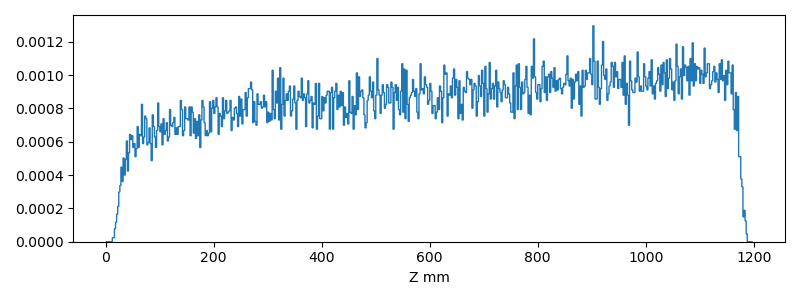

In [36]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

bins = np.arange(0, 1200, 2)

ax.hist(tracks.z_ave, bins=bins, histtype="step", label="Track", density=True)

ax.set_xlabel("Z mm")
fig.tight_layout();

## Tracks

In [9]:
sel = dsts.loc[(dsts.nS1 == 1) & (dsts.nS2 == 1), ("event", "file")]
tracks = tracks.set_index(["event", "file"]).loc[sel.values.tolist()]

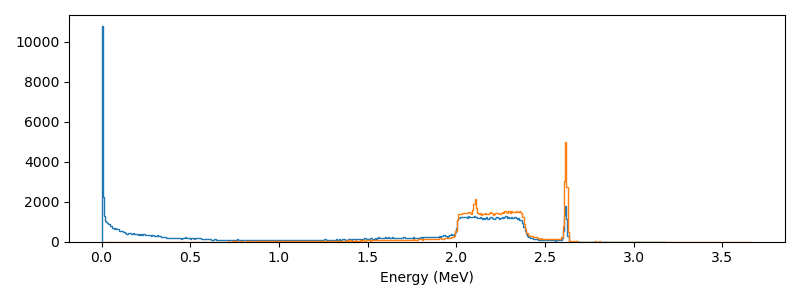

In [10]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)
ax.hist(tracks.energy, bins=500, histtype="step", label="Track")
# ax.set_xlabel("Track energy (MeV)")
# fig.tight_layout();

# fig = plt.figure(figsize=[8, 2])
# ax = fig.add_subplot(111)
ax.hist(tracks.groupby(level=[0,1]).energy.sum(), bins=500, histtype="step", label="Total")
ax.set_xlabel("Energy (MeV)")
fig.tight_layout();

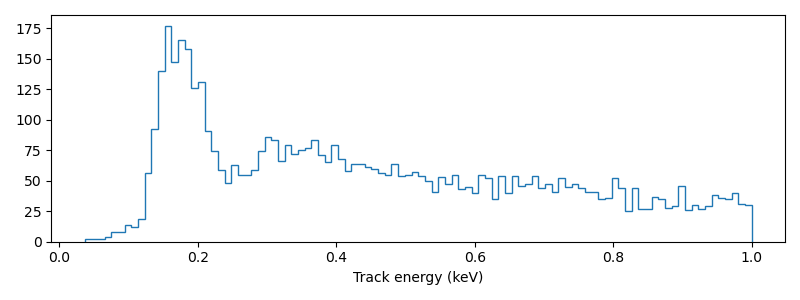

In [11]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

sel = tracks.energy<0.001
ax.hist(tracks.loc[sel].energy*1e3, bins=100, histtype="step", label="Track")
ax.set_xlabel("Track energy (keV)")
fig.tight_layout();

In [12]:
spurious_energy = (0.25 * keV)/MeV

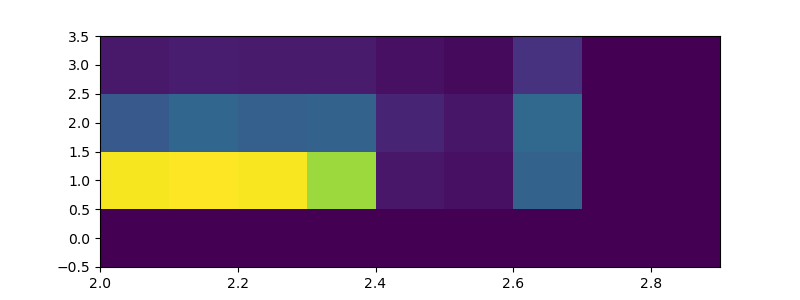

In [13]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)
e   = tracks.groupby(level=[0,1]).energy.sum()
ntr = tracks.groupby(level=[0,1]).trackID.nunique()

ebins = np.arange(2, 3, 0.1)
nbins = np.arange(-0.5, 4.5, 1)
ax.hist2d(e, ntr, bins=(ebins, nbins));

In [36]:
# select photopeak
total_e = tracks.groupby(level=[0,1]).energy.sum()

ph = total_e[total_e>2.6]

# choose random event
event_file = ph.sample(1).index
event, file = event_file[0]

tracks.loc[event_file]

trackID    energy     length  numb_of_voxels  numb_of_hits  \
event     file                                                               
180866648 671         0  2.236286  76.973342              59          3935   
          671         1  0.377893  18.977043              10           506   

                numb_of_tracks    x_min    y_min       z_min       r_min  ...  \
event     file                                                            ...   
180866648 671                2 -327.325   62.675  663.190447  281.044500  ...   
          671                2 -222.325  113.675  706.028872  239.645595  ...   

                   blob1_z     blob2_x     blob2_y     blob2_z    eblob1  \
event     file                                                             
180866648 671   684.649300 -267.072836   94.071472  696.711772  0.291764   
          671   712.827986 -220.626385  119.256827  706.028872  0.377893   

                  eblob2  ovlp_blob_energy  vox_size_x  vox_size_y  vox_size_z  
event     file                                                                  
180866648 671   0.240059          0.000000    9.833333         9.0    4.806695  
          671   0.377893          0.377893    9.833333         9.0    4.806695  

[2 rows x 36 columns]

In [37]:
# filename = os.path.dirname(filenames[0]) + f"/isaura_{file}_{isotope}.h5"

# eventMap = load_dst(filename, "Run", "eventMap") .set_index("evt_number")
# mchits   = load_dst(filename,  "MC", "hits")     .set_index("event_id").loc[eventMap.loc[event].nexus_evt]
# particles= load_dst(filename,  "MC", "particles").set_index("event_id").loc[eventMap.loc[event].nexus_evt]

# mchits    = mchits   .set_index("particle_id")
# particles = particles.set_index("particle_id")

In [49]:
# columns = ("particle_name", "mother_id", "kin_energy", "creator_proc", "final_proc",
#            "initial_x")

# particles.loc[(particles.final_proc != "eIoni"), columns]

# particles.loc[(particles.kin_energy>0.1), columns]

In [48]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(mchits.x, mchits.y, mchits.z, c=mchits.energy)

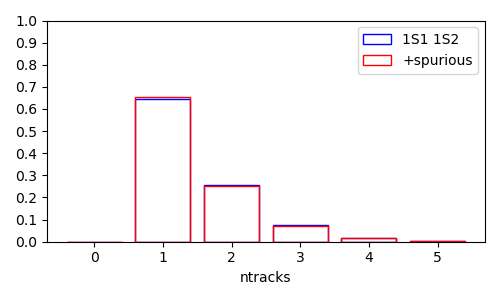

In [22]:
fig = plt.figure(figsize=[5, 3])

bins  = np.arange(-0.5, 6.5)
binsc = (bins[1:] + bins[:-1])/2.

# 1S1 1S2 selection
ax = fig.add_subplot(1, 1, 1)

h, _ = np.histogram(tracks.groupby(level=[0, 1]).trackID.nunique(), bins=bins)
ax.set_xlabel("ntracks")
ax.bar(binsc, h/h.sum(), tick_label=binsc.astype(int), color="none", edgecolor="b", label="1S1 1S2")

# spurious selection
tracks_ = tracks.loc[tracks.energy>spurious_energy]

h, _ = np.histogram(tracks_.groupby(level=[0, 1]).trackID.nunique(), bins=bins)
ax.set_xlabel("ntracks")
ax.bar(binsc, h/h.sum(), tick_label=binsc.astype(int), color="none", edgecolor="r", label="+spurious")
ax.set_yticks(np.arange(0, 1.1, 0.1))
fig.tight_layout()
ax.legend()

In [14]:
# remove spurious tracks and assign energy to largest energy track:
# sum spurious track energies to max energy track and
# correct numb_of_tracks values

tracks = tracks.set_index("trackID", append=True)

sel_spurious = (tracks.energy < spurious_energy)
spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

# trackID of max energy track
trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                .set_index("trackID", append=True).groupby(level=[0, 1]) \
                .apply(lambda df: df.energy.idxmax()[-1])
trackID.name = "trackID"

# sum spurious energy to max energy track
spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                    .set_index("trackID", append=True)
tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

# drop spurious
tracks = tracks.loc[~sel_spurious].reset_index("trackID")
# correct numb of tracks
tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

# how-to select spurious events
# event_has_spurious = sel_spurious.to_frame().groupby(level=[0, 1]).energy.any()
# tracks.reset_index("trackID").loc[event_has_spurious]

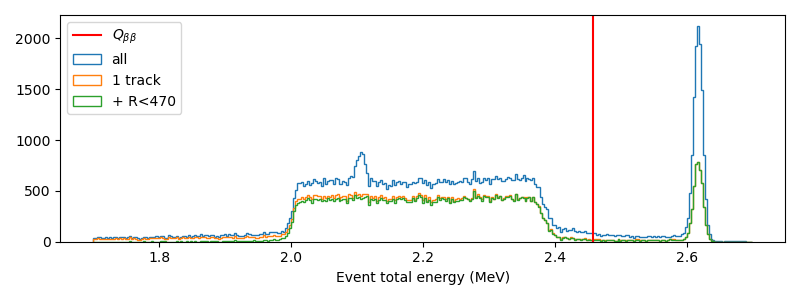

In [30]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

bins = np.arange(1.7, 2.7, 0.003)

ax.hist(tracks.groupby(level=[0, 1]).energy.sum(), bins=bins, histtype="step", label="all")

sel = (tracks.numb_of_tracks == 1)
ax.hist(tracks.loc[sel].energy, bins=bins, histtype="step", label="1 track")

rcut = 470
sel = sel & (tracks.r_max < rcut)
ax.hist(tracks.loc[sel].energy, bins=bins, histtype="step", label=f"+ R<{rcut}")

# zmin, zmax = 20, 1150
# sel = sel & (zmin < tracks.z_ave) & (tracks.z_ave < zmax)
# ax.hist(tracks.loc[sel].energy, bins=bins, histtype="step", label=f"+ {zmin} < z < {zmax}")

Qbb = 2.458
ax.axvline(Qbb, color="r", label=r"$Q_{\beta\beta}$")

ax.set_xlabel("Event total energy (MeV)")
ax.legend(loc="upper left")
fig.tight_layout();

# 1 track selection

In [31]:
sel = (tracks.numb_of_tracks == 1)
tracks = tracks.loc[sel]

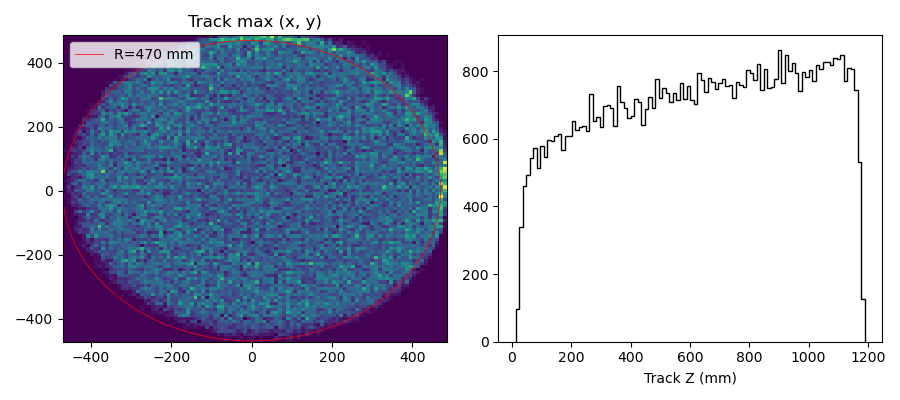

In [32]:
fig = plt.figure(figsize=[9, 4])
ax = fig.add_subplot(121)
ax.hist2d(tracks.x_max, tracks.y_max, bins=100)
ax.set_title("Track max (x, y)")
fig.tight_layout();

r = 470
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(r*np.cos(theta), r*np.sin(theta), label=f"R={r} mm", color="r", linewidth=0.5)
ax.legend(loc="upper left")

ax = fig.add_subplot(122)
ax.hist(tracks.z_ave, bins=100, histtype="step", color="k")
ax.set_xlabel("Track Z (mm)")
fig.tight_layout();

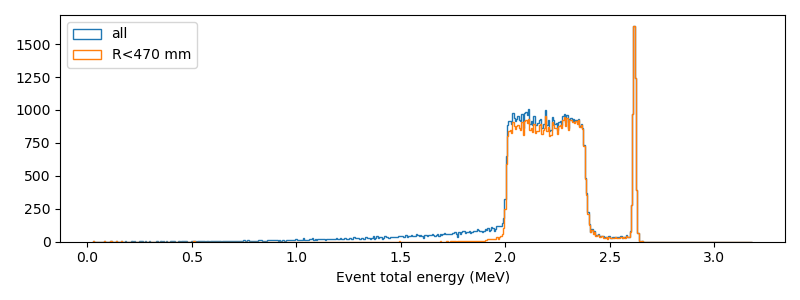

In [34]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

_, bins, _ = ax.hist(tracks.groupby(level=[0, 1]).energy.sum(), bins=500, histtype="step", label="all")

rmax = 470
sel = tracks.groupby(level=[0, 1]).apply(lambda df: df.r_max.max()) < rmax
ax.hist(tracks.loc[sel].groupby(level=0).energy.sum(), bins=bins, histtype="step", label=f"R<{rmax} mm")

ax.set_xlabel("Event total energy (MeV)")
ax.legend(loc="upper left")
fig.tight_layout();

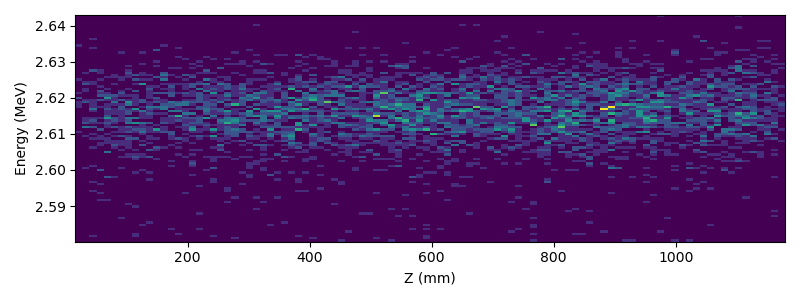

In [37]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

emin, emax = 2.58, 2.65
sel = (emin<tracks.energy)&(tracks.energy < emax)

ax.hist2d(tracks.loc[sel].z_ave, tracks.loc[sel].energy, bins=100);
ax.set_xlabel("Z (mm)")
ax.set_ylabel("Energy (MeV)")
fig.tight_layout();

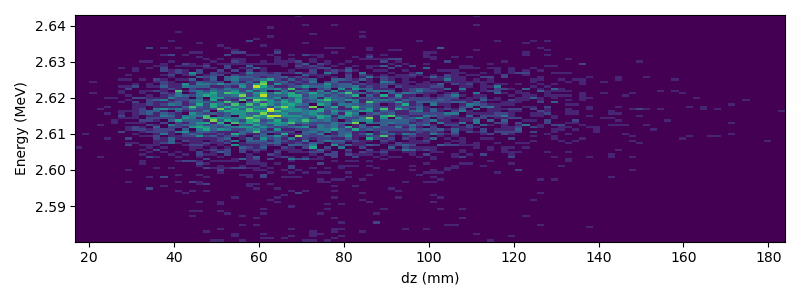

In [38]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

# sel = tracks.energy>2.36
ax.hist2d((tracks.loc[sel].z_max - tracks.loc[sel].z_min), tracks.loc[sel].energy, bins=100);
ax.set_xlabel("dz (mm)")
ax.set_ylabel("Energy (MeV)")
fig.tight_layout();